# Курсовой проект

Выполнил: Каган Елизавета

## Библиотеки

### Установка

In [19]:
! git clone https://github.com/facebookresearch/fastText.git
! pip3 install fastText/.

fatal: destination path 'fastText' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./fastText
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4384288 sha256=5c8517f114db263b0b6978de1dbbbca9913b25142337514a250556efc5f0f05a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ozm0obpd/wheels/8b/05/af/3cfae069d904597d44b309c956601b611bdf8967bcbe968903
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


In [20]:
! pip install fasttext --quiet
! gdown --id 1su3IYY1avcj95tez69JI8f5qsTng72-I

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1su3IYY1avcj95tez69JI8f5qsTng72-I
To: /content/rudrec_fasttext_model.bin
100% 2.05G/2.05G [00:24<00:00, 85.1MB/s]


In [21]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
!pip install rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
!pip install scattertext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Импортирование

In [27]:
import pandas as pd
import numpy as np
import math
from itertools import *
from copy import deepcopy

import time
from datetime import datetime

In [28]:
# Визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
from wordcloud import WordCloud
import scattertext as st
from IPython.display import IFrame
from IPython.core.display import display, HTML

In [29]:
import json
import rarfile

import re
from warnings import filterwarnings
filterwarnings('ignore')

In [30]:
import fasttext

# NLTK
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import Text

import pymorphy2

from keras_preprocessing import sequence
from keras_preprocessing.text import Tokenizer

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow import keras
from tensorflow.keras import  Sequential, layers

import torch
from torch import nn, optim
#from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification, Trainer, TrainingArguments

In [32]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
folder = '/content/gdrive/My Drive/text_data/'

In [34]:
RANDOM_SEED = 42
tensorflow.random.set_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Данные

In [ ]:
# Материалы решений судебных дел

# case_id - идентиикационный номер дела
# text - полный текст решения
# cleaned_sn_motive_text
# first_level_ID, CategoryID - категория дела

df_prep = pd.read_csv(folder+'130k_bert_df.csv')['case_id', 'text', 'cleaned_sn_motive_text', 'first_level_ID', 'CategoryID']

In [21]:
print('Shape: ', df_prep.shape)

df_prep.head(5)

Shape:  (128427, 7)
Columns:  Index(['corpus130k_id', 'text', 'CategoryID', 'case_id',
       'cleaned_sn_motive_text', 'first_level_ID', 'bert_id'],
      dtype='object')


,corpus130k_id,text,CategoryID,case_id,cleaned_sn_motive_text,first_level_ID,bert_id
0,0,Смоленская область\nАС Смоленской области\nПеч...,114,А62-3945/2007,Комитетом имущественных и земельных отношений...,113,23
1,1,Смоленская область\nАС Смоленской области\nПуз...,190,А62-3321/2007,;Государственное учреждение Управление Пенсио...,189,31
2,2,Смоленская область\nАС Смоленской области\nБор...,114,А62-4164/2007,предпринимателем Григорьевой Г.А. (далее пред...,113,23
3,4,Смоленская область\nАС Смоленской области\nПуз...,114,А62-25/2007,;Государственное учреждение Управление Пенсио...,113,23
4,5,Смоленская область\nАС Смоленской области\nЕро...,190,А62-2088/2007,": -:;В соответствии со ст.ст 14, 22, 23, 24 Ф...",189,31


In [26]:
# Метки категории

category_lev1 = pd.unique(df_prep.first_level_ID.values)
print(len(category_lev1), sorted(category_lev1), '\n')

category_id = pd.unique(df_prep.CategoryID.values)
print(len(category_id), sorted(category_id), '\n')

29 [1, 3, 4, 9, 11, 13, 14, 18, 19, 21, 22, 23, 24, 25, 38, 41, 46, 77, 93, 95, 113, 121, 130, 151, 159, 189, 193, 199, 200] 

35 [1, 3, 4, 9, 11, 13, 14, 18, 19, 21, 22, 23, 24, 25, 26, 39, 42, 46, 47, 83, 93, 99, 101, 114, 123, 128, 131, 140, 157, 161, 170, 190, 193, 199, 200] 



In [ ]:
# Таксономия
# ID ~ CategoryID

df_info = pd.read_csv(folder+'categs_info_old.csv').drop('Unnamed: 0', axis = 1)

df_info[df_info.ID.isin(category_id)]

### Распределение по категориям

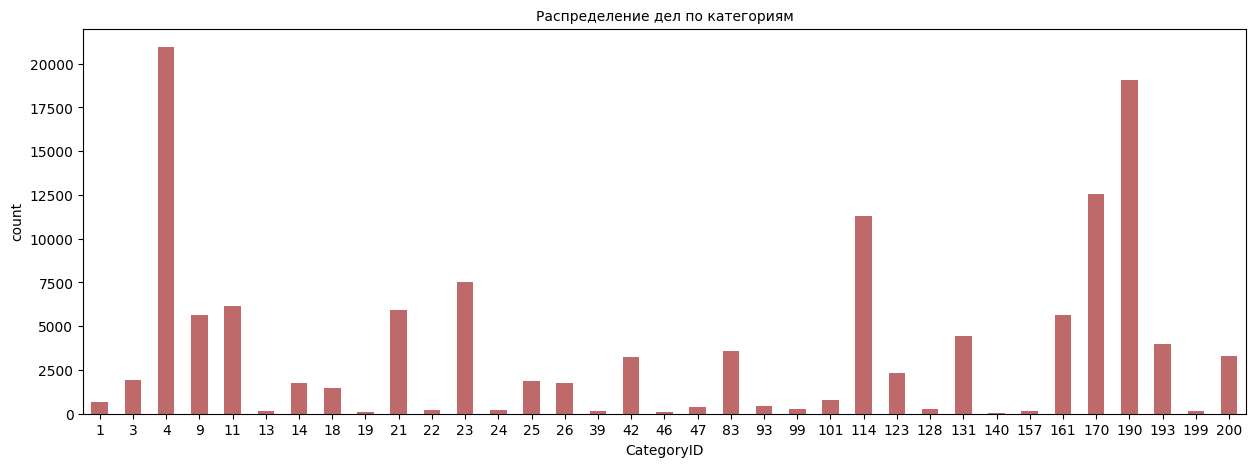

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.countplot(data=df_prep, x='CategoryID', width=0.5, color='indianred', ax=axs)
axs.set_title('Распределение дел по категориям', fontsize=10)
plt.show()

In [45]:
# Проверка на пропуски

if np.sum(df_prep.isnull().sum().values) > 0:
    print('В данных присутствуют пропуски.')
    print(df_prep.isnull().sum())
else:
    print('В данных нет пропусков.')

В данных нет пропусков.


### Пример

In [29]:
ex = 7
df_prep.loc[ex]

corpus130k_id                                                             8
text                      Смоленская область\nАС Смоленской области\nЕро...
CategoryID                                                              170
case_id                                                        А62-933/2007
cleaned_sn_motive_text     -:;В соответствии с Положением утв. Постановл...
first_level_ID                                                          159
bert_id                                                                  30
Name: 7, dtype: object

In [30]:
# решение суда
print(df_prep.loc[ex, 'text'])

Смоленская область
АС Смоленской области
Ерохина Юлия Викторовна
Арбитраж
А62-933/2007
А62-933/2007
Первая инстанция

Решение суда первой инстанции: Отказать в удовл. треб. адм. органов о привлечении к адм. отв.
28.03.2007

решение
<p style="text-align:center"></p>
<p style="text-align:center"><b>АРБИТРАЖНЫЙ СУД СМОЛЕНСКОЙ ОБЛАСТИ</b></p>
<p style="text-align:center"><b>ИМЕНЕМ РОССИЙСКОЙ ФЕДЕРАЦИИ</b></p>
<p style="text-align:center"><b>РЕШЕНИЕ </b></p>
<p style="text-align:center"><b>&nbsp;</b></p>
<p>г. Смоленск                                                                                              Дело №  А-62-933/2007</p>
<p>&nbsp;</p>
<p>«28»  марта 2007 года</p>
<p>Резолютивная часть решения объявлена «28» марта 2007 года. Полный текст решения  изготовлен  «28»  марта 2007 года</p>
<p style="text-align:right"><b>&nbsp;</b></p>
<p><b>  </b>Арбитражный суд Смоленской области в составе: судьи Ерохиной Ю.В.</p>
<p>при ведении протокола судебного заседания помощником судьи Сергее

In [31]:
print(df_prep.loc[ex, 'cleaned_sn_motive_text'])

 -:;В соответствии с Положением утв. Постановлением Правительства РФ от 14.08.2002  600 Об утверждении положения о лицензировании негосударственной (частной) охранной деятельности, Приказа МВД РФ от 19.06.2006  447 Об утверждении Инструкции об организации работы по лицензированию и осуществлению органами внутренних дел контроля за частной детективной и охранной деятельностью на территории Российской Федерации на основании распоряжения заместителя начальника УВД по Смоленской области от 27.02.2007  195 28.02.2007 проведена проверка ООО ЧОП Скорпион по вопросу соблюдения последним лицензионных требований, о чем составлен акт от 28.02.2007.В ходе проверки установлено, что 07.02.2007 в ООО ЧОП Скорпион, расположенном по адресу: г.Смоленск Краснинское шоссе д.35, согласно приказа  17к в качестве охранника был принят гражданин Нефедов Н.М., который 27.02.2007 в нарушение п.4-б Положения утв. Постановлением Правительства РФ от 14.08.2002  600 был направлен руководителем ЧОП для осуществления 

In [51]:
print(len(df_prep.loc[ex, 'cleaned_sn_motive_text'].split()))

273


# Предобработка данных

In [48]:
# Список стоп-слов

russian_stopwords = stopwords.words("russian")
left_ = ['не', 'нет', 'нельзя', 'даже', 'почти', 'наконец', 'много', 'вcегда', 'более', 'лучше', 'хорошо']

In [49]:
morph = pymorphy2.MorphAnalyzer()

def clean(text):
    # приводим к нижнему регистру
    text = text.lower()

    # разбиваем на токены
    tokens = word_tokenize(text)

    # лемматизация: приводим токены к начальной форме
    for i in range (len(tokens)):
            tokens[i] = morph.parse(tokens[i])[0].normal_form

    # удаляем стоп-слова
    tokens = [token for token in tokens if ((token not in russian_stopwords) or (token in left_))]

    # убираем все, что не слова или цифры
    tokens =  [token for token in tokens if token.isalnum()]

    #cur_len = len(tokens) # считаем кол-во токенов после очистки
    text = " ".join(tokens)
    return text

def clean_texts(texts):
    cleaned_txt = [clean(str(t)) for t in texts.values]
    return cleaned_txt

In [62]:
target_col = 'cleaned_sn_motive_text'
#df = deepcopy(df_prep.loc[0:50000])
df = deepcopy(df_prep)

In [64]:
df['cleaned'] = clean_texts(df[target_col])
df['cleaned_len'] = df['cleaned'].apply(lambda x: len(x.split(' ')))

# Сохранение промежуточных результатов
df.to_excel(folder+'data_tmp.xlsx')

Загружаем предобработанные данные

In [37]:
col_list = ['case_id', 'text', 'cleaned_sn_motive_text', 'cleaned', 'cleaned_len', 'first_level_ID', 'CategoryID']
label_col = 'CategoryID'
text_col = 'cleaned'

df = pd.read_excel(folder+'data_tmp.xlsx')[col_list]

In [38]:
df = df[df[label_col].isin([4, 9, 11, 21, 23, 42, 47])]

print(df.shape)

(49906, 7)


In [39]:
df_info = pd.read_csv(folder+'categs_info_old.csv').drop('Unnamed: 0', axis = 1)

In [42]:
df_info[df_info['ID'].isin([4, 9, 11, 21, 23, 42, 47])][['ID', 'Descr']]

,ID,Descr
3,4,Споры о неисполнении или ненадлежащем исполнен...
8,9,Споры о неисполнении или ненадлежащем исполнен...
10,11,Споры о неисполнении или ненадлежащем исполнен...
20,21,Споры о неисполнении или ненадлежащем исполнен...
22,23,Споры о неисполнении или ненадлежащем исполнен...
41,42,Споры о признании права собственности
46,47,Споры об обжаловании решений Роспатента


# Анализ данных

In [56]:
def get_freq_dist(texts):
    text_tokens = str()
    for txt in texts.values:
        text_tokens += txt
    text_tokens = text_tokens.split()
    text = Text(text_tokens)
    fdist = FreqDist(text)
    return fdist

In [62]:
def plot_word_cloud(texts):
    text = ' '.join(texts)
    # генерируем облако слов
    cloud = WordCloud(width=1000, height=800,
                      background_color='white',
                      stopwords=['суд', 'арбитражный', 'российский', 'федерация']).generate(text)
    plt.imshow(cloud)
    plt.axis('off')

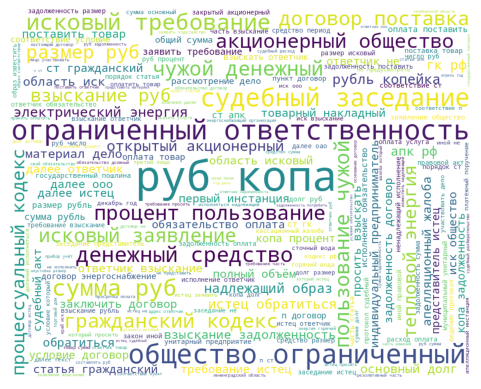

In [63]:
plot_word_cloud(df[df['CategoryID'] == 4].cleaned.values)

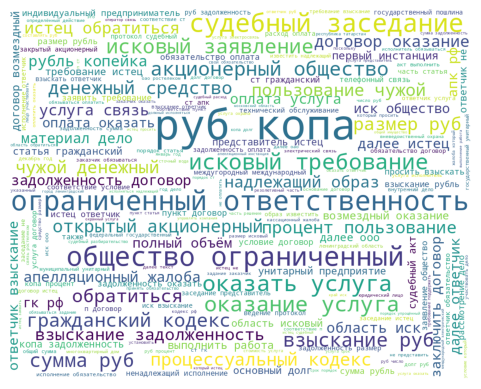

In [65]:
plot_word_cloud(df[df['CategoryID'] == 23].cleaned.values)

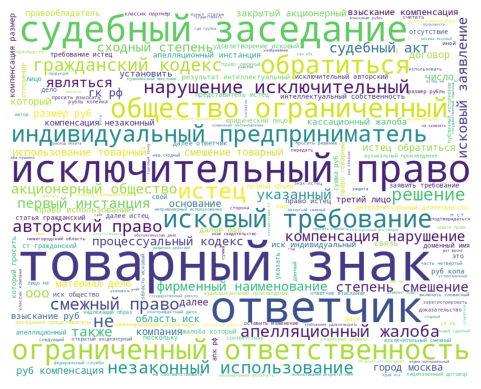

In [66]:
plot_word_cloud(df[df['CategoryID'] == 47].cleaned.values)

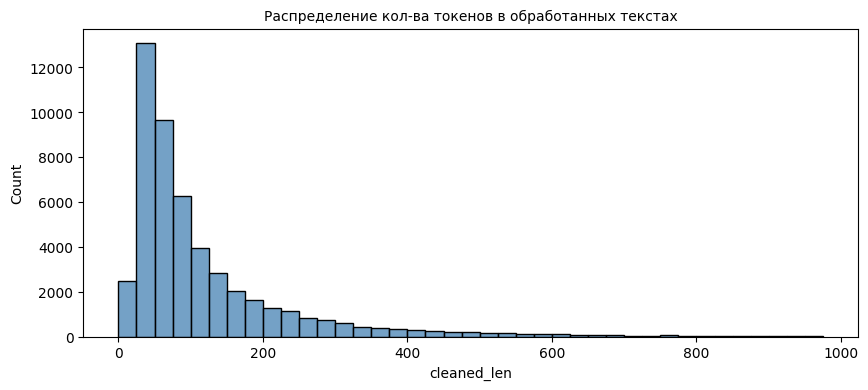

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.histplot(data=df, x='cleaned_len', bins=np.arange(0, 1000, 25), color = 'steelblue',ax=axs)
axs.set_title("Распределение кол-ва токенов в обработанных текстах", fontsize=10)
plt.show()

# Разбиение выборки

In [43]:
def split_data(data, test_size = 0.2, valid_size = 0, label_col = 'CategoryID'):
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=RANDOM_SEED, stratify = data[label_col])
    if valid_size != 0:
        data_train, data_valid = train_test_split(data_train, test_size=valid_size, random_state=RANDOM_SEED, stratify = data_train[label_col])
    else:
        data_valid= None
    return data_train, data_valid, data_test

In [44]:
df_train, df_valid, df_test = split_data(df, valid_size = 0.15, test_size = 0.2)

Train: shape = 33935 

Test: shape = 9982 

Validation: shape = 5989 



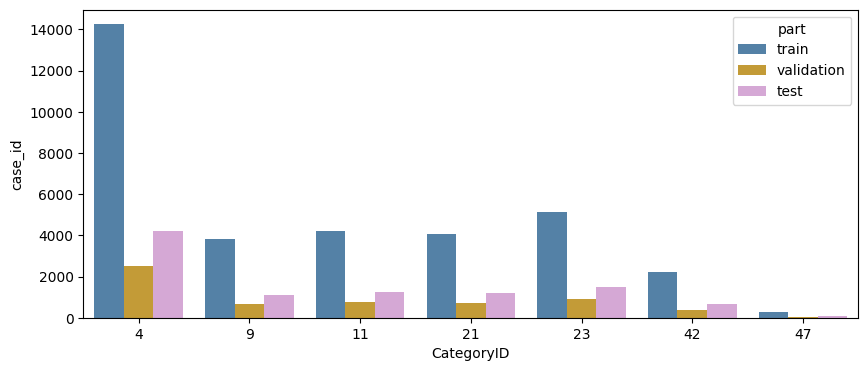

In [45]:
print(f'Train: shape = {df_train.shape[0]} \n')
df_1 = df_train.groupby([label_col]).count()[['case_id']].reset_index()
df_1['part'] = ['train']*df_1.shape[0]

print(f'Test: shape = {df_test.shape[0]} \n'),
df_2 = df_test.groupby([label_col]).count()[['case_id']].reset_index()
df_2['part'] = ['test']*df_2.shape[0]

if df_valid is not None:
    print(f'Validation: shape = {df_valid.shape[0]} \n')
    df_3 = df_valid.groupby([label_col]).count()[['case_id']].reset_index()
    df_3['part'] = ['validation']*df_3.shape[0]
    df_share = pd.concat([df_1, df_3, df_2], axis=0).reset_index()
else:
    df_share = pd.concat([df_1, df_2], axis=0).reset_index()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.barplot(data=df_share, x=label_col, y='case_id', hue='part', ax=axs, palette=['steelblue', 'goldenrod', 'plum'])
#axs.set_title("Распределение ", fontsize=10)
plt.show()

# Модели

In [46]:
label_dict, i = {}, 0
for c in pd.unique(df.CategoryID.values):
    label_dict[c] = i
    i += 1
print(label_dict)

{11: 0, 9: 1, 4: 2, 42: 3, 23: 4, 21: 5, 47: 6}


In [47]:
train_texts, valid_texts, test_texts = df_train[text_col].values, df_valid[text_col].values, df_test[text_col].values

train_labels = df_train[label_col].apply(lambda x: label_dict[x]).values
valid_labels = df_valid[label_col].apply(lambda x: label_dict[x]).values
test_labels = df_test[label_col].apply(lambda x: label_dict[x]).values

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

word_index = tokenizer.word_index
dictionary_size = len(word_index.keys()) + 1

In [49]:
train_to_seq = tokenizer.texts_to_sequences(train_texts)
valid_to_seq = tokenizer.texts_to_sequences(valid_texts)

In [50]:
max_len = 600 #max(train_df['length'].values)

train_seq_pad = sequence.pad_sequences(train_to_seq, maxlen=max_len)
valid_seq_pad = sequence.pad_sequences(valid_to_seq, maxlen=max_len)

In [51]:
test_to_seq = tokenizer.texts_to_sequences(test_texts)
test_seq_pad = sequence.pad_sequences(test_to_seq, maxlen=max_len)

## Эмбеддинги

FastText

In [52]:
emb_size=200

fasttext_model = fasttext.load_model('rudrec_fasttext_model.bin')

embedding_matrix = np.zeros((dictionary_size, emb_size))

for word, i in word_index.items():
    embedding_vector = fasttext_model.get_word_vector((word))
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector

## Text CNN

In [71]:
class CNN_for_text(Model):

    def __init__(self, maxlen, max_features,
                 embedding_dims, embedding_weights,
                 kernel_sizes=[3, 4, 5],
                 class_num=1, last_activation='sigmoid',):
        super(CNN_for_text, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.kernel_sizes = kernel_sizes
        self.class_num = class_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen, weights=[embedding_weights], )
        self.convs = []
        self.max_poolings = []
        for kernel_size in self.kernel_sizes:
            self.convs.append(Conv1D(128, kernel_size, activation='relu'))
            self.max_poolings.append(GlobalMaxPooling1D())
        self.classifier = Dense(self.class_num, activation=self.last_activation)

    def call(self, inputs):
        embedding = self.embedding(inputs)
        convs = []
        for i in range(len(self.kernel_sizes)):
            c = self.convs[i](embedding)
            c = self.max_poolings[i](c)
            convs.append(c)
        x = Concatenate()(convs)
        output = self.classifier(x)
        return output

In [74]:
model = CNN_for_text(maxlen=max_len, max_features=dictionary_size,
                embedding_dims=emb_size, embedding_weights=embedding_matrix,
                class_num=7, last_activation='softmax')

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5 , mode='max', restore_best_weights=True)

In [75]:
model_hist = model.fit(train_seq_pad, train_labels,
        batch_size=128,
        epochs=10,
        callbacks=[early_stopping, ],
        validation_data=(valid_seq_pad, valid_labels))

Epoch 1/10
266/266 [==============================] - 1277s 5s/step - loss: 0.5990 - accuracy: 0.7986 - val_loss: 0.4081 - val_accuracy: 0.8621
Epoch 2/10
266/266 [==============================] - 1283s 5s/step - loss: 0.3256 - accuracy: 0.8904 - val_loss: 0.3863 - val_accuracy: 0.8709
Epoch 3/10
266/266 [==============================] - 1247s 5s/step - loss: 0.2108 - accuracy: 0.9363 - val_loss: 0.3763 - val_accuracy: 0.8754
Epoch 4/10
266/266 [==============================] - 1271s 5s/step - loss: 0.1186 - accuracy: 0.9720 - val_loss: 0.3776 - val_accuracy: 0.8798
Epoch 5/10
266/266 [==============================] - 1266s 5s/step - loss: 0.0547 - accuracy: 0.9909 - val_loss: 0.3947 - val_accuracy: 0.8758
Epoch 6/10
266/266 [==============================] - 1251s 5s/step - loss: 0.0274 - accuracy: 0.9969 - val_loss: 0.3986 - val_accuracy: 0.8840
Epoch 7/10
266/266 [==============================] - 1267s 5s/step - loss: 0.0140 - accuracy: 0.9983 - val_loss: 0.4111 - val_accuracy:

In [81]:
model.summary()

Model: "cnn_for_text_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  16150200  
                                                                 
 conv1d_9 (Conv1D)           multiple                  76928     
                                                                 
 conv1d_10 (Conv1D)          multiple                  102528    
                                                                 
 conv1d_11 (Conv1D)          multiple                  128128    
                                                                 
 global_max_pooling1d_9 (Glo  multiple                 0         
 balMaxPooling1D)                                                
                                                                 
 global_max_pooling1d_10 (Gl  multiple                 0         
 obalMaxPooling1D)                                  

In [79]:
predicted_valid_prob = model.predict(valid_seq_pad)
valid_res = pd.DataFrame(data=predicted_valid_prob)
valid_res.to_excel(folder+'valid_prob.xlsx')

In [80]:
predicted_test_prob = model.predict(test_seq_pad)
test_res = pd.DataFrame(data=predicted_test_prob)
test_res.to_excel(folder+'test_prob.xlsx')

312/312 [==============================] - 97s 311ms/step


In [88]:
valid_pred_label = []
for i in valid_res.index:
    valid_pred_label.append(np.argmax(valid_res.loc[i].values))

In [92]:
print(len(valid_labels), len(valid_pred_label))
print('Доля верно определенных категорий на валидационной выборке равна = ', round(np.sum(valid_pred_label == valid_labels)/len(valid_pred_label), 2))

5989 5989
Доля верно определенных категорий на валидационной выборке равна =  0.88


In [94]:
test_pred_label = []
for i in test_res.index:
    test_pred_label.append(np.argmax(test_res.loc[i].values))

print(len(test_labels), len(test_pred_label))
print('Доля верно определенных категорий на тестовой выборке равна = ', round(np.sum(test_pred_label == test_labels)/len(test_pred_label), 2))

9982 9982
Доля верно определенных категорий на тестовой выборке равна =  0.88


Для каждого класса посчитаем матрицу ошибок

In [96]:
from sklearn.metrics import confusion_matrix

count of true negatives (TN) is C_0,0\
false negatives (FN) is C_1, 0\
true positives (TP) is C_1, 1\
false positives (FP) is C_0, 1

In [132]:
def calculate_table(ar_labels, ar_pred, c_list):
    res_matrix = pd.DataFrame(columns=['TP', 'TN', 'FN', 'FP'])
    for c in c_list:
        y_true = np.where(np.array(ar_labels) == c, 1, 0)
        y_pred = np.where(np.array(ar_pred) == c, 1, 0)
        cm = confusion_matrix(y_true, y_pred)
        res_matrix.loc[c] = [cm[1][1], cm[0][0], cm[1][0], cm[0][1]]
    res_matrix['precision'] = res_matrix['TP'] / (res_matrix['TP'] + res_matrix['FP'])
    res_matrix['recall'] = res_matrix['TP'] / (res_matrix['TP'] + res_matrix['FN'])
    res_matrix['F1'] = 2* res_matrix['precision'] * res_matrix['recall'] / (res_matrix['precision'] + res_matrix['recall'])
    res_matrix['categoryID'] = label_dict.keys()
    return res_matrix

In [133]:
valid_table = calculate_table(valid_pred_label, valid_labels, label_dict.values())
test_table = calculate_table(test_pred_label, test_labels, label_dict.values())

In [134]:
print(test_table)

     TP    TN   FN   FP  precision    recall        F1  categoryID
0   912  8596  151  323   0.738462  0.857949  0.793734          11
1   961  8758   97  166   0.852706  0.908318  0.879634           9
2  3891  5295  496  300   0.928418  0.886939  0.907204           4
3   614  9282   47   39   0.940276  0.928896  0.934551          42
4  1198  8099  372  313   0.792852  0.763057  0.777670          23
5  1165  8777   16   24   0.979815  0.986452  0.983122          21
6    62  9906    0   14   0.815789  1.000000  0.898551          47


In [164]:
def plot_result(df, part='test', color='plum'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    sns.barplot(data=df, x='categoryID', y='precision', width = 0.5, color=color, ax=axs[0])
    axs[0].set_title(f'mean precision on {part} = {round(np.mean(df.precision), 2)}', fontsize=10)
    sns.barplot(data=df, x='categoryID', y='recall', width = 0.5, color=color, ax=axs[1])
    axs[1].set_title(f'mean recall = {round(np.mean(valid_table.recall), 2)}', fontsize=10)
    plt.show()

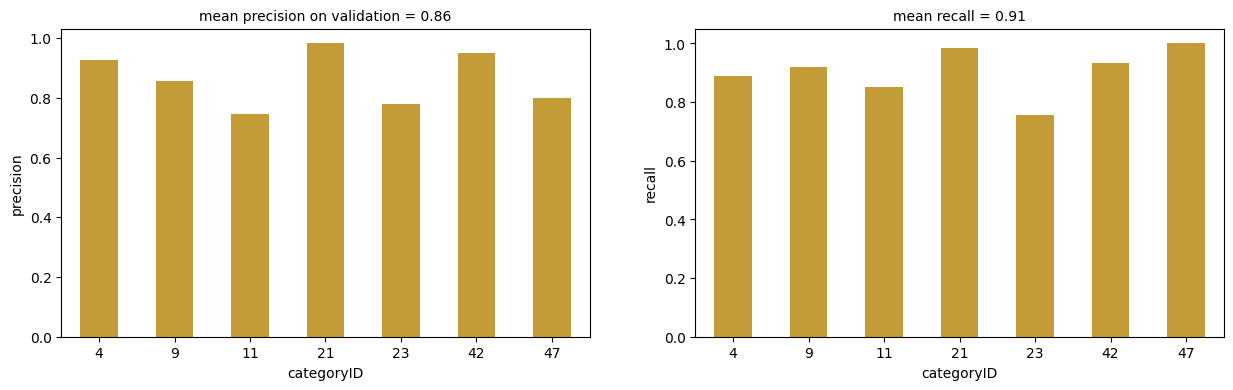

In [165]:
plot_result(valid_table, part='validation', color='goldenrod')

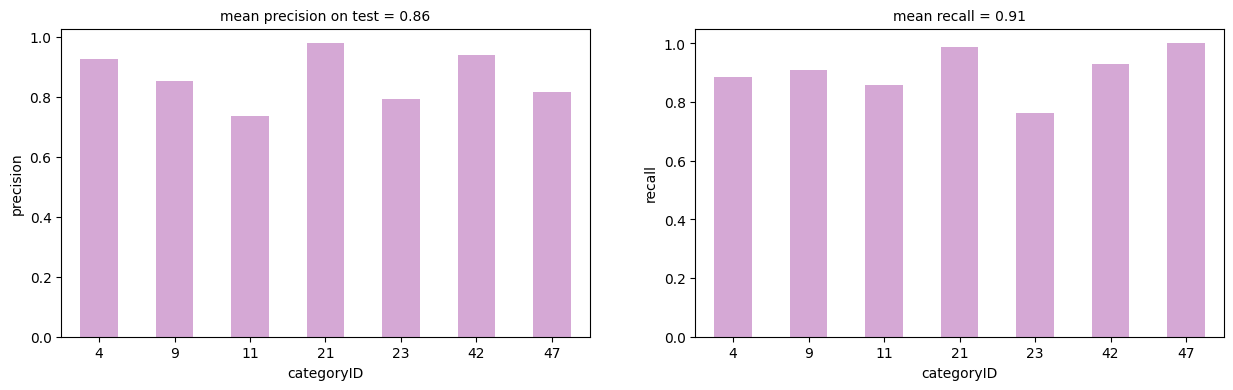

In [166]:
plot_result(test_table)

In [172]:
RA_valid = roc_auc_score(valid_labels, predicted_valid_prob, multi_class='ovr')
print(f'ROC-AUC on validation = {RA_valid}')

RA_test = roc_auc_score(test_labels, predicted_test_prob, multi_class='ovr')
print(f'ROC-AUC on test = {RA_test}')

ROC-AUC on validation = 0.9834798896735517
ROC-AUC on test = 0.983474409676362
